# CANCELACION

Para predecir si una reserva futura se cancelará o no, estás en un escenario de clasificación, no de clustering. La diferencia principal es que la clasificación tiene etiquetas conocidas (en este caso, "cancelado" o "no cancelado") y el objetivo es predecir estas etiquetas para nuevas reservas. El clustering, en cambio, agrupa datos sin etiquetas predefinidas.

Aquí tienes cómo ajustar tu enfoque para una tarea de clasificación:

1. Preparación de Datos
Primero, asegúrate de que tus datos estén listos para el modelo. Esto incluye:

Eliminar o Imputar Valores Faltantes: Ya lo has hecho en pasos anteriores.
Codificación de Variables Categóricas: Usar OneHotEncoder como lo has hecho.
Escalado de Características Numéricas: Usar StandardScaler como lo has hecho.

2. Definir el Preprocesador y el Pipeline para Clasificación
Definir el Preprocesador:

Asegúrate de incluir todas las variables que consideres relevantes para la predicción, y convierte las variables categóricas en formato numérico.

Crear el Pipeline:

Aquí se sustituye el KMeans por un clasificador, por ejemplo, LogisticRegression. Asegúrate de ajustar el número de clusters para los modelos de clustering o usar clasificadores adecuados.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay

# PASO 1 | Importamos archivo

In [2]:
df = pd.read_csv('../data/02_processed/df_final_modelar.csv')
df.head()

,Posición,Llegada,Salida,Apartamento,Portal de reserva,Creado,Adultos,Niños,Check-in,Check-out,...,Mensaje_Huesped,BOOKING_NOTE,GENIUS,Numero_Huespedes,Lead_Time,ADR,Precio_Medio_Historico,Fecha,Apartamentos_Ocupados,Porcentaje_Ocupacion
0,32474470,2022-12-30,2023-01-01,H BMA MONACO,Booking.com,2022-12-30 15:16:00,1.0,1.0,16:00,11:00,...,NaN,Payment charge is EUR 2.5839,True,2.0,0 days 15:16:00,117.45,110.427971,2022-12-30,12.0,29.268293
1,32470780,2022-12-30,2022-12-31,H BMA HELSINKI,Booking.com,2022-12-30 13:38:00,2.0,0.0,16:00,11:00,...,NaN,Payment charge is EUR 1.045,True,2.0,0 days 13:38:00,95.00,111.276875,2022-12-30,12.0,29.268293
2,32407618,2022-12-31,2023-01-01,H BMA DUBLIN,Booking.com,2022-12-28 20:36:00,4.0,0.0,16:00,11:00,...,NaN,Payment charge is EUR 2.695,True,4.0,-3 days +20:36:00,245.00,121.511303,2022-12-31,16.0,39.024390
3,32401555,2022-12-28,2022-12-30,HD-GARAJE 5,Reserva directa,2022-12-28 18:20:00,0.0,0.0,16:00,11:00,...,NaN,NaN,False,0.0,0 days 18:20:00,20.00,14.154531,2022-12-28,21.0,51.219512
4,32400367,2022-12-31,2023-01-01,HD DARIO,Booking.com,2022-12-28 17:53:00,2.0,0.0,16:00,11:00,...,NaN,Payment charge is EUR 2.211,True,2.0,-3 days +17:53:00,201.00,108.699008,2022-12-31,16.0,39.024390


# PASO 2 | EXPLORACION BÁSICA de los DATOS

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14170 entries, 0 to 14169
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Posición                14170 non-null  int64  
 1   Llegada                 14170 non-null  object 
 2   Salida                  14170 non-null  object 
 3   Apartamento             14170 non-null  object 
 4   Portal de reserva       14170 non-null  object 
 5   Creado                  14170 non-null  object 
 6   Adultos                 14170 non-null  float64
 7   Niños                   14170 non-null  float64
 8   Check-in                14170 non-null  object 
 9   Check-out               14170 non-null  object 
 10  Notas                   13352 non-null  object 
 11  Precio                  14170 non-null  float64
 12  Detalles de precios     12585 non-null  object 
 13  Comisión incluida       14170 non-null  float64
 14  Pagado                  14170 non-null

El conjunto de datos consta de 14,170 entradas.

Columnas: El conjunto de datos contiene 31 columnas, que representan diversos atributos relacionados con las reservas de hotel.

Tipos de Datos:

La mayoría de las columnas, 18 para ser precisos, son de tipo de dato objeto (a menudo representan cadenas de texto o datos categóricos).
2 columnas son de tipo de dato int64, que representan valores enteros.
10 columnas son de tipo de dato float64, que típicamente denota valores decimales.
1 columnas son de tipo de dato booleano

Valores Faltantes:

La columna Notas tiene 818 valores faltantes.
La columna Detalles de precios tiene 1,584 valores faltantes.
La columna Número de reserva tiene 3,795 valores faltantes.
La columna Mensaje_Huesped tiene un número significativo de valores faltantes, totalizando 12,189.
La columna BOOKING_NOTE tiene 3,802 valores faltantes.

Estos valores faltantes podrían necesitar ser tratados, dependiendo del contexto del análisis o del modelo que se pretende construir.

In [4]:
df['GENIUS'] = df['GENIUS'].astype(str)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Posición,14170.0,4.253946e+07,1.435905e+07,1.539014e+07,2.989671e+07,4.215626e+07,5.392231e+07,6.985467e+07
Adultos,14170.0,2.463726e+00,1.482575e+00,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,8.000000e+00
Niños,14170.0,3.607622e-01,7.820496e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00
Precio,14170.0,2.300720e+02,2.917964e+02,1.150000e+00,8.200000e+01,1.480000e+02,2.720000e+02,7.847600e+03
Comisión incluida,14170.0,3.109997e+01,3.794185e+01,0.000000e+00,1.065000e+01,2.053500e+01,3.834000e+01,8.677500e+02
Número de noches,14170.0,1.816161e+00,1.950443e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,8.100000e+01
Numero_Reserva,10375.0,3.643374e+09,8.287956e+08,1.005919e+09,2.935646e+09,3.816649e+09,4.266050e+09,5.000159e+09
Numero_Huespedes,14170.0,2.824488e+00,1.639560e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,8.000000e+00
ADR,14170.0,1.238623e+02,8.256586e+01,1.150000e+00,7.100000e+01,1.020000e+02,1.583333e+02,1.502700e+03
Precio_Medio_Historico,14170.0,1.143600e+02,4.101778e+01,1.000000e+01,9.658330e+01,1.104951e+02,1.234379e+02,3.316667e+02


# Variables Numericas
<p>· Posición: Numero de registro en el sistema de gestion de propiedad. (PMS)</p>
<p>· Adultos: Adultos en la reserva.</p>
<p>· Niños: Niños en la reserva.</p>
<p>· Precio: Valor total del ticket.</p>
<p>· Comisión incluida: Importe pagado al intermediario.</p>
<p>· Número de noches: Número de noches en la reserva.</p>
<p>· Numero_Reserva: Número de la reserva. </p>
<p>· Numero_Huespedes: Numero de personas, adultos y niños, que incluye la reserva.</p>
<p>· ADR: Previo por día vendido en la reserva.</p>
<p>· Precio_Medio_Historico: Precio Medio histósrico para ese apartamento y día.</p>
<p>· Apartamentos_Ocupados: Número de apartamentos ocupadas en ese día.</p>
<p>· Porcentaje_Ocupacion: Porcentaje de ocupación total del portfolio. </p>

# Características de Datos Ruidosos: 

<p>Basado en las descripciones y las inferencias proporcionadas anteriormente, las siguientes características parecen contener datos ruidosos:</p>


<p> Adultos: El valor mínimo es 0, lo que implica reservas sin ningún adulto. Esto podría ser un error de entrada de datos, a menos que haya casos legítimos en los que solo niños o bebés reserven una habitación.</p>
<p> Niños: Tiene un valor máximo de 7, lo cual parece inusualmente alto para una sola reserva. Esto podría ser un posible valor atípico o un error de entrada de datos, pero requeriría más contexto o conocimiento del dominio para decirlo con certeza. </p>

Una investigación adicional, posiblemente involucrando expertos en el dominio o contexto adicional, sería necesaria para determinar la verdadera naturaleza de estos puntos de datos. </p>

In [5]:
df.describe(include='object').T

,count,unique,top,freq
Llegada,14170,1015,2024-05-24,36
Salida,14170,1019,2024-05-26,45
Apartamento,14170,41,HD BRUNO,691
Portal de reserva,14170,4,Booking.com,10387
Creado,14170,13652,2024-06-03 13:18:00,8
Check-in,14170,1,16:00,14170
Check-out,14170,1,11:00,14170
Notas,13352,12819,efectivo,18
Detalles de precios,12585,3718,IVA - EUR 5.36,107
Pagado,14170,2,Sí,11449


# Variables Categóricas
<p>· Llegada: Fecha de llegada al apartamento</p>
<p>· Salida: Fecha de salida del apartamento.</p>
<p>· Apartamento: Apartamento reservado.</p>
<p>· Portal de reserva: Canal por donde se hizo la reserva.</p>
<p>· Creado: Fecha en que se hizo la reserva.</p>
<p>· Check-in: Hora de entrada.</p>
<p>· Check-out: Hora de salida. </p>
<p>· Notas: Campo que viene del canal Booking con información de la reserva.</p>
<p>· Detalles de precios: Desglose del IVA.</p>
<p>· Pagado: Sí o No según la reserva esté pagada o no.</p>
<p>· Adelanto ya pagado: Sí o No según hayan pagado un adelanto.</p>
<p>· Estado: Estado de la reserva: Reservado, cancelado. </p>
<p>· Teléfono_Token: Numero de teléfono del cliente TOKENIZADO por protección de datos sensibles.</p>
<p>· Email_Token: Email del cliente TOKENIZADO por protección de datos sensibles.</p>
<p>· Mensaje_Huesped: Extarído de Notas. Algunos canales en el campo Notas dejan los mensajes específicos del cliente en el momento de la reserva.</p>
<p>· GENIUS: Es del Programa Genius de Booking.com? Sí o No..</p>
<p>· Lead_Time: Tiempo de antelación con la que está hecha la reserva. </p>
<p>· Fecha: Es una variable creada para poder calcular la ocupación el día en el que entra el huésped. </p>

# PASO 3 | Selección de Features 

<p>En la etapa de Selección y Creación de Características, preparamos el conjunto de datos para el modelado realizando varias actividades cruciales:</p>

<p>Eliminación de Características Directamente Relacionadas: Eliminamos características que están directamente relacionadas con la variable objetivo para evitar la filtración de datos y asegurar una evaluación justa del modelo.</p>
<p>Eliminación de Características Irrelevantes: A continuación, eliminamos características irrelevantes que no aportan información útil para predecir la variable objetivo.</p>
<p>Ingeniería y Eliminación de Características de Alta Cardinalidad: Creamos algunas características de alta cardinalidad para extraer información relevante y luego eliminamos todas las características de alta cardinalidad, incluidas aquellas de las que extrajimos información.</p>
<p>Estas actividades ayudan a reducir la dimensionalidad del conjunto de datos, a evitar la filtración de datos y a crear nuevas características que pueden proporcionar información adicional para el modelo.</p>

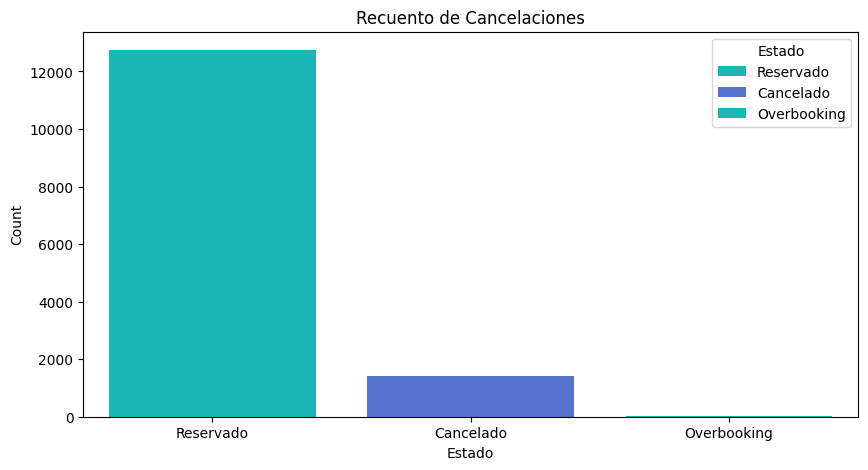

In [6]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Estado', hue='Estado', data=df, palette=['darkturquoise', 'royalblue'])
plt.title('Recuento de Cancelaciones')
plt.xlabel('Estado')
plt.ylabel('Count')
plt.legend(title='Estado', labels=['Reservado', 'Cancelado', 'Overbooking'])
plt.show()

In [7]:
print(df['Lead_Time'].head(10))

0      0 days 15:16:00
1      0 days 13:38:00
2    -3 days +20:36:00
3      0 days 18:20:00
4    -3 days +17:53:00
5    -2 days +12:14:00
6      0 days 09:31:00
7    -2 days +22:22:00
8    -2 days +21:12:00
9    -3 days +22:17:00
Name: Lead_Time, dtype: object


In [8]:
df['Lead_Time'].isnull().sum()


0

In [9]:
df['Lead_Time'].describe()

count               14170
unique              11035
top       0 days 12:30:00
freq                   13
Name: Lead_Time, dtype: object

In [10]:
# Convertir 'Lead_Time' a timedelta
df['Lead_Time'] = pd.to_timedelta(df['Lead_Time'])
# Convertir 'Lead_Time' a número de días
df['Lead_Time_Days'] = df['Lead_Time'].dt.total_seconds() / (24 * 3600)
# Eliminar la columna original si ya no es necesaria
df = df.drop(columns=['Lead_Time'])
print(df[['Lead_Time_Days']].head())
print(df.dtypes)

   Lead_Time_Days
0        0.636111
1        0.568056
2       -2.141667
3        0.763889
4       -2.254861
Posición                    int64
Llegada                    object
Salida                     object
Apartamento                object
Portal de reserva          object
Creado                     object
Adultos                   float64
Niños                     float64
Check-in                   object
Check-out                  object
Notas                      object
Precio                    float64
Detalles de precios        object
Comisión incluida         float64
Pagado                     object
Adelanto ya pagado         object
Número de noches            int64
Estado                     object
Huésped_Token              object
Teléfono_Token             object
Email_Token                object
Numero_Reserva            float64
Mensaje_Huesped            object
BOOKING_NOTE               object
GENIUS                     object
Numero_Huespedes          float64
ADR     

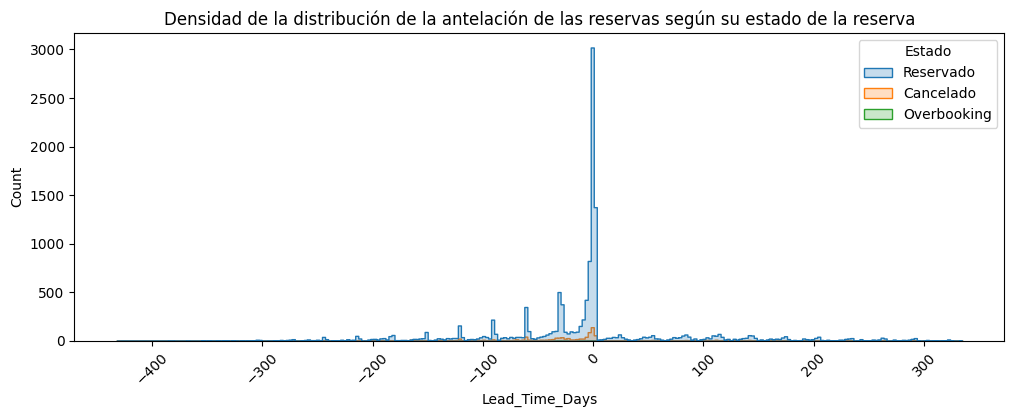

In [11]:
plt.figure(figsize=(12, 4))
sns.histplot(data=df, x="Lead_Time_Days", hue="Estado", element="step", stat="count", common_norm=False)
plt.title('Densidad de la distribución de la antelación de las reservas según su estado de la reserva')
plt.xticks(rotation=45)  # Inclina los valores del eje X en 90 grados
plt.show()


# PASO 4 | Eliminar Features con Alta Cardinalidad.
Esto es valores únicos o con muchísimas opciones diferentes.

In [12]:
df.describe(include='object').T

,count,unique,top,freq
Llegada,14170,1015,2024-05-24,36
Salida,14170,1019,2024-05-26,45
Apartamento,14170,41,HD BRUNO,691
Portal de reserva,14170,4,Booking.com,10387
Creado,14170,13652,2024-06-03 13:18:00,8
Check-in,14170,1,16:00,14170
Check-out,14170,1,11:00,14170
Notas,13352,12819,efectivo,18
Detalles de precios,12585,3718,IVA - EUR 5.36,107
Pagado,14170,2,Sí,11449


In [13]:
# Vamos a crea run dataframe específico con el número de catgorías únicas y valores faltantes para cada feature de alta-cardinalidad.
Alta_cardinalidad_features = ['Huésped_Token', 'Posición', 'Notas', 'Teléfono_Token', 'Email_Token', 'Fecha','Salida', 'Llegada']
Categorias_unicas = df[Alta_cardinalidad_features].nunique()
Valores_Faltantes = df[Alta_cardinalidad_features].isnull().sum()

# Combinamos las dos series en un único dataframe
Alta_cardinalidad_df = pd.DataFrame({'Unicas_Categorias': Categorias_unicas, 'Missing_Values': Valores_Faltantes})

Alta_cardinalidad_df

,Unicas_Categorias,Missing_Values
Huésped_Token,14170,0
Posición,14153,0
Notas,12819,818
Teléfono_Token,14170,0
Email_Token,14170,0
Fecha,1015,0
Salida,1019,0
Llegada,1015,0


# Eliminar la variable 'Huésped_Token' y otras de alta cardinalidad

In [14]:
# Crear una nueva columna 'Reservas_Hechas' que cuenta el número de reservas hechas por cada cliente basado en su nombre
df['Reservas_Hechas'] = df.groupby('Huésped_Token')['Huésped_Token'].transform('count')

# Eliminar la variable 'Huésped_Token' y otras de alta cardinalidad
df = df.drop(['Huésped_Token', 'Posición', 'Notas', 'Teléfono_Token', 'Email_Token', 'Numero_Reserva', 'Check-out', 'Check-in', 'Creado', 'Salida', 'Llegada', 'Fecha', 'Detalles de precios', 'BOOKING_NOTE'], axis=1)

# Visualizar las primeras filas de la nueva columna
df[['Reservas_Hechas']].head()
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14170 entries, 0 to 14169
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Apartamento             14170 non-null  object 
 1   Portal de reserva       14170 non-null  object 
 2   Adultos                 14170 non-null  float64
 3   Niños                   14170 non-null  float64
 4   Precio                  14170 non-null  float64
 5   Comisión incluida       14170 non-null  float64
 6   Pagado                  14170 non-null  object 
 7   Adelanto ya pagado      14170 non-null  object 
 8   Número de noches        14170 non-null  int64  
 9   Estado                  14170 non-null  object 
 10  Mensaje_Huesped         1981 non-null   object 
 11  GENIUS                  14170 non-null  object 
 12  Numero_Huespedes        14170 non-null  float64
 13  ADR                     14170 non-null  float64
 14  Precio_Medio_Historico  14170 non-null

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14170 entries, 0 to 14169
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Apartamento             14170 non-null  object 
 1   Portal de reserva       14170 non-null  object 
 2   Adultos                 14170 non-null  float64
 3   Niños                   14170 non-null  float64
 4   Precio                  14170 non-null  float64
 5   Comisión incluida       14170 non-null  float64
 6   Pagado                  14170 non-null  object 
 7   Adelanto ya pagado      14170 non-null  object 
 8   Número de noches        14170 non-null  int64  
 9   Estado                  14170 non-null  object 
 10  Mensaje_Huesped         1981 non-null   object 
 11  GENIUS                  14170 non-null  object 
 12  Numero_Huespedes        14170 non-null  float64
 13  ADR                     14170 non-null  float64
 14  Precio_Medio_Historico  14170 non-null

In [16]:
df['Adultos'].value_counts()

Adultos
2.0    6078
3.0    2094
1.0    1943
4.0    1893
0.0     974
5.0     525
6.0     387
7.0     197
8.0      79
Name: count, dtype: int64

In [17]:
condicion = df['Adultos'] == 0
df[condicion].describe()

,Adultos,Niños,Precio,Comisión incluida,Número de noches,Numero_Huespedes,ADR,Precio_Medio_Historico,Apartamentos_Ocupados,Porcentaje_Ocupacion,Lead_Time_Days,Reservas_Hechas
count,974.0,974.000000,974.000000,974.000000,974.000000,974.000000,974.000000,974.000000,974.000000,974.000000,974.000000,974.0
mean,0.0,0.004107,133.369867,0.025257,2.534908,0.004107,40.686159,45.270959,29.890144,72.902790,-1.697468,1.0
std,0.0,0.090582,464.499448,0.788235,4.712747,0.090582,46.350005,47.483138,6.998109,17.068559,88.087654,0.0
min,0.0,0.000000,10.000000,0.000000,1.000000,0.000000,3.333333,10.000000,6.000000,14.634146,-381.221528,1.0
25%,0.0,0.000000,20.000000,0.000000,1.000000,0.000000,20.000000,16.868211,23.000000,56.097561,-29.403299,1.0
50%,0.0,0.000000,40.000000,0.000000,1.000000,0.000000,20.000000,19.316261,31.000000,75.609756,-0.298958,1.0
75%,0.0,0.000000,77.000000,0.000000,2.000000,0.000000,54.000000,82.172536,31.000000,75.609756,0.749826,1.0
max,0.0,2.000000,7847.600000,24.600000,62.000000,2.000000,900.000000,241.082737,41.000000,100.000000,323.885417,1.0


In [18]:
df['Niños'].value_counts()

Niños
0.0    11268
2.0     1493
1.0     1086
3.0      269
4.0       43
5.0        6
6.0        4
7.0        1
Name: count, dtype: int64

In [19]:
df['Reservas_Hechas'].value_counts()

Reservas_Hechas
1    14170
Name: count, dtype: int64

# Numerizar las variables Categóricas

In [20]:
# One-hot encode the specified columns
one_hot_cols = ['Apartamento', 'Estado', 'Portal de reserva', 'GENIUS', 'Adelanto ya pagado', 'Pagado']
df_dummies = pd.get_dummies(df, columns=one_hot_cols, drop_first=False)

df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14170 entries, 0 to 14169
Data columns (total 67 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Adultos                            14170 non-null  float64
 1   Niños                              14170 non-null  float64
 2   Precio                             14170 non-null  float64
 3   Comisión incluida                  14170 non-null  float64
 4   Número de noches                   14170 non-null  int64  
 5   Mensaje_Huesped                    1981 non-null   object 
 6   Numero_Huespedes                   14170 non-null  float64
 7   ADR                                14170 non-null  float64
 8   Precio_Medio_Historico             14170 non-null  float64
 9   Apartamentos_Ocupados              14170 non-null  float64
 10  Porcentaje_Ocupacion               14170 non-null  float64
 11  Lead_Time_Days                     14170 non-null  flo

In [21]:
import pandas as pd

# Lista de columnas que deseas transformar
columnas_a_transformar = ['Mensaje_Huesped']

# Crear nuevas columnas indicando si están informadas (1) o no (0)
for col in columnas_a_transformar:
    df_dummies[f'{col}_Informada'] = df[col].notna().astype(int)
    

In [22]:
df_dummies.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14170 entries, 0 to 14169
Data columns (total 68 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Adultos                            14170 non-null  float64
 1   Niños                              14170 non-null  float64
 2   Precio                             14170 non-null  float64
 3   Comisión incluida                  14170 non-null  float64
 4   Número de noches                   14170 non-null  int64  
 5   Mensaje_Huesped                    1981 non-null   object 
 6   Numero_Huespedes                   14170 non-null  float64
 7   ADR                                14170 non-null  float64
 8   Precio_Medio_Historico             14170 non-null  float64
 9   Apartamentos_Ocupados              14170 non-null  float64
 10  Porcentaje_Ocupacion               14170 non-null  float64
 11  Lead_Time_Days                     14170 non-null  flo

In [23]:
print(df_dummies['Lead_Time_Days'].head(10))
df_dummies['Lead_Time_Days'].isnull().sum()
df_dummies['Lead_Time_Days'].describe()

0    0.636111
1    0.568056
2   -2.141667
3    0.763889
4   -2.254861
5   -1.490278
6    0.396528
7   -1.068056
8   -1.116667
9   -2.071528
Name: Lead_Time_Days, dtype: float64


count    14170.000000
mean        -7.995974
std         94.407082
min       -432.023611
25%        -32.535590
50%         -1.581597
75%          0.659549
max        334.530556
Name: Lead_Time_Days, dtype: float64

In [24]:
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14170 entries, 0 to 14169
Data columns (total 68 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Adultos                            14170 non-null  float64
 1   Niños                              14170 non-null  float64
 2   Precio                             14170 non-null  float64
 3   Comisión incluida                  14170 non-null  float64
 4   Número de noches                   14170 non-null  int64  
 5   Mensaje_Huesped                    1981 non-null   object 
 6   Numero_Huespedes                   14170 non-null  float64
 7   ADR                                14170 non-null  float64
 8   Precio_Medio_Historico             14170 non-null  float64
 9   Apartamentos_Ocupados              14170 non-null  float64
 10  Porcentaje_Ocupacion               14170 non-null  float64
 11  Lead_Time_Days                     14170 non-null  flo

# PASO 5 | Comprobación Datos No Balanceados


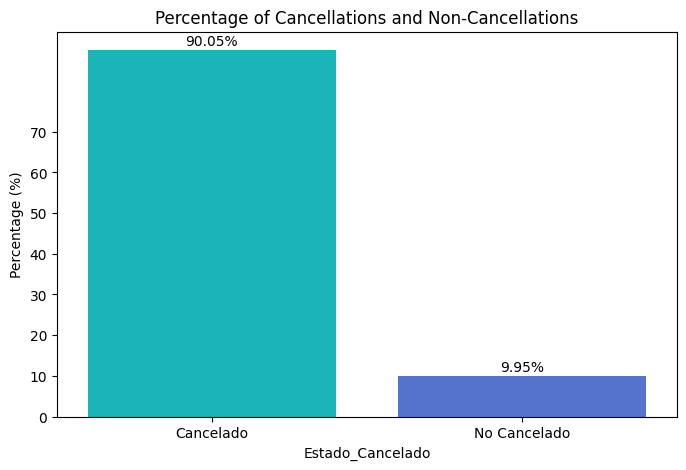

In [25]:
percentage = df_dummies['Estado_Cancelado'].value_counts(normalize=True) * 100

# Plotting the percentage of each class
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=percentage.index, y=percentage, palette=['darkturquoise', 'royalblue'])
plt.title('Percentage of Cancellations and Non-Cancellations')
plt.xlabel('Estado_Cancelado')
plt.ylabel('Percentage (%)')
plt.xticks(ticks=[0, 1], labels=['Cancelado', 'No Cancelado'])
plt.yticks(ticks=range(0,80,10))

# Displaying the percentage on the bars
for i, p in enumerate(percentage):
    ax.text(i, p + 0.5, f'{p:.2f}%', ha='center', va='bottom')

plt.show()

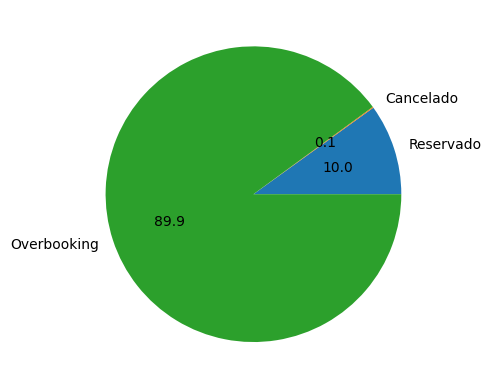

In [26]:
plt.pie(df.groupby(by=["Estado"]).size(), labels = df["Estado"].unique(), autopct = "%0.1f")
plt.show()

In [27]:
# Lista de columnas que quieres eliminar
columns_to_remove = ['Salida', 'Detalles de precios', 'Mensaje_Huesped', 'BOOKING_NOTE']  # Reemplaza con tus nombres de columnas

# Eliminar columnas del DataFrame
df_dummies = df_dummies.drop(columns=columns_to_remove, errors='ignore')
print(df_dummies)

       Adultos  Niños  Precio  Comisión incluida  Número de noches  \
0          1.0    1.0  234.90              35.23                 2   
1          2.0    0.0   95.00              14.25                 1   
2          4.0    0.0  245.00              36.75                 1   
3          0.0    0.0   40.00               0.00                 2   
4          2.0    0.0  201.00              30.15                 1   
...        ...    ...     ...                ...               ...   
14165      1.0    0.0  520.00               0.00                 4   
14166      7.0    0.0  159.25              23.89                 1   
14167      6.0    0.0  521.60              78.24                 2   
14168      5.0    0.0  671.80             100.77                 2   
14169      7.0    0.0  261.80              35.70                 2   

       Numero_Huespedes     ADR  Precio_Medio_Historico  \
0                   2.0  117.45              110.427971   
1                   2.0   95.00          

array([[<Axes: title={'center': 'Adultos'}>,
        <Axes: title={'center': 'Niños'}>,
        <Axes: title={'center': 'Precio'}>,
        <Axes: title={'center': 'Comisión incluida'}>],
       [<Axes: title={'center': 'Número de noches'}>,
        <Axes: title={'center': 'Numero_Huespedes'}>,
        <Axes: title={'center': 'ADR'}>,
        <Axes: title={'center': 'Precio_Medio_Historico'}>],
       [<Axes: title={'center': 'Apartamentos_Ocupados'}>,
        <Axes: title={'center': 'Porcentaje_Ocupacion'}>,
        <Axes: title={'center': 'Lead_Time_Days'}>,
        <Axes: title={'center': 'Reservas_Hechas'}>],
       [<Axes: title={'center': 'Mensaje_Huesped_Informada'}>, <Axes: >,
        <Axes: >, <Axes: >]], dtype=object)

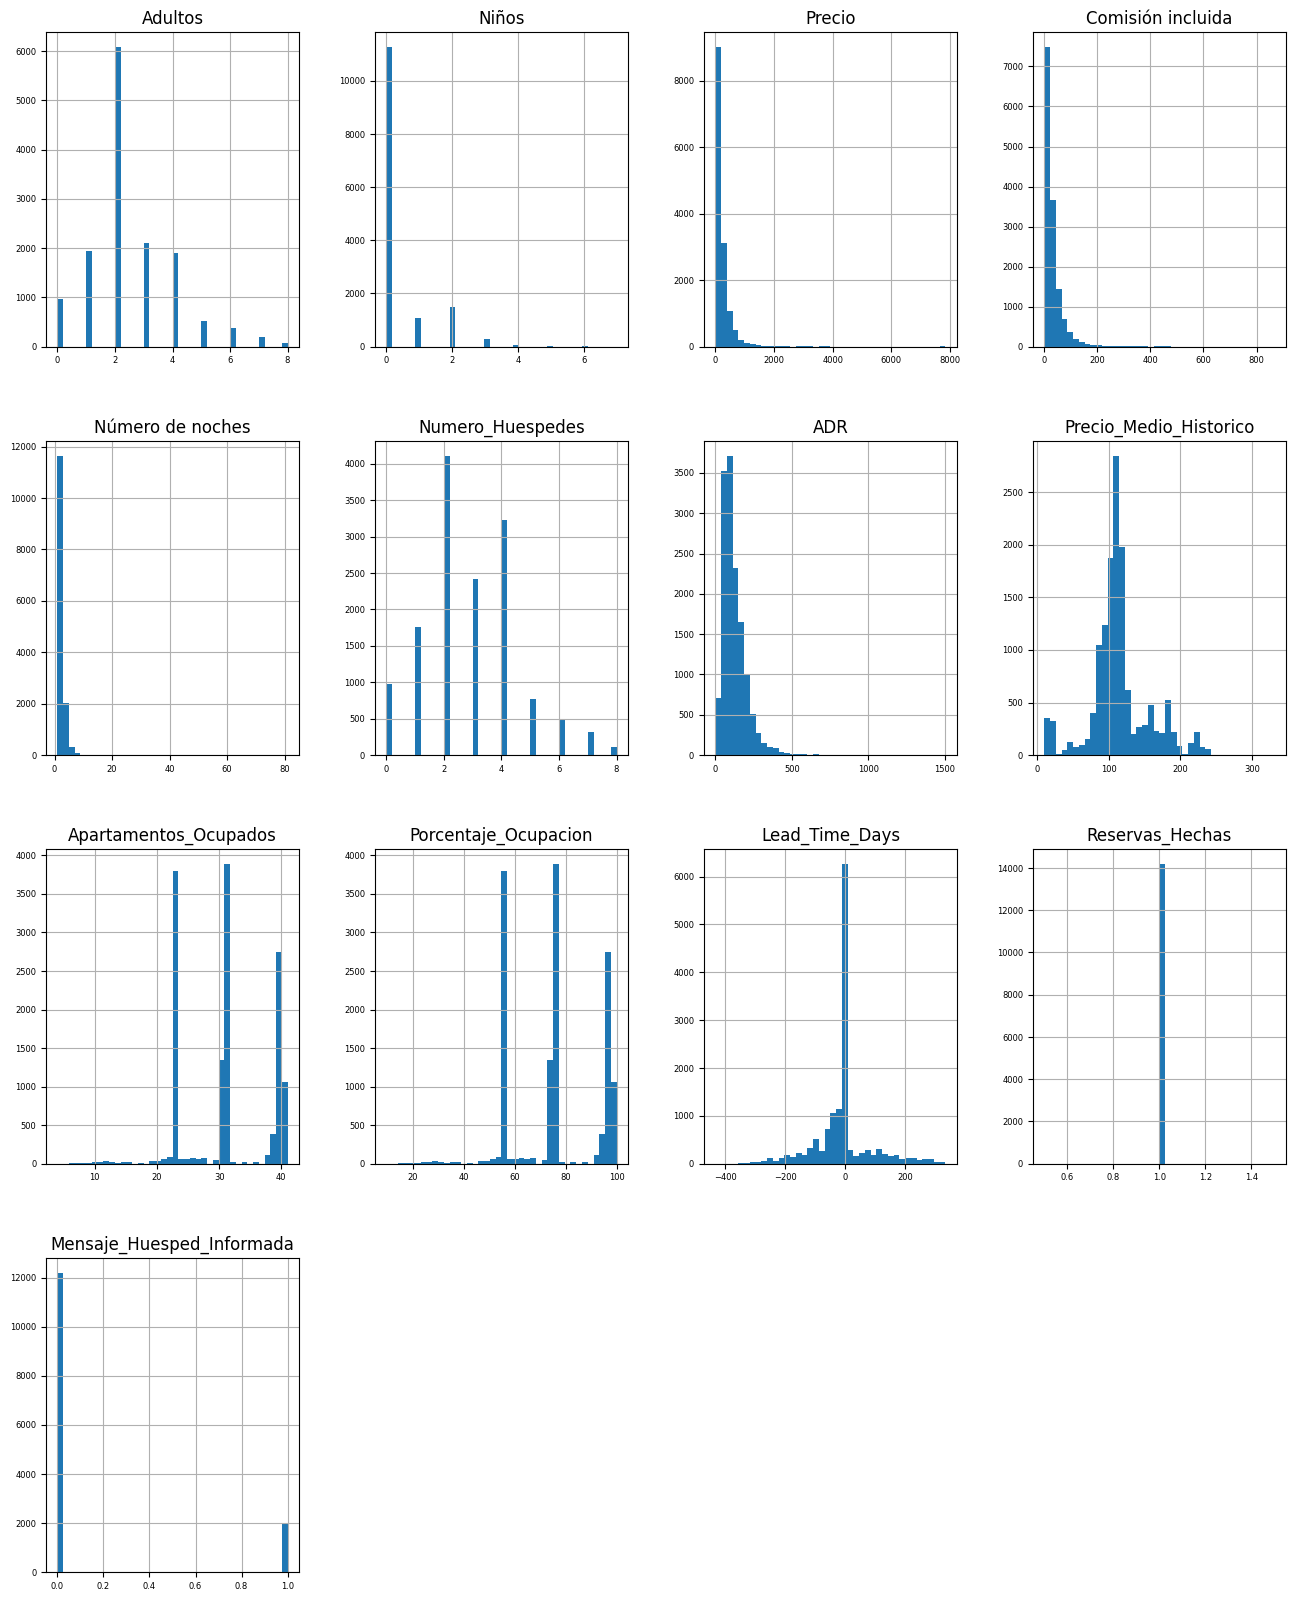

In [28]:
df_num = df_dummies.select_dtypes(include = ['float64', 'int64'])
df_num.hist(figsize=(16, 20), bins=40, xlabelsize=6, ylabelsize=6)

# PASO 6 | MODELOS

In [29]:
from sklearn.model_selection import train_test_split

X_train = df_dummies.drop('Estado_Cancelado', axis=1)  # asumiendo que 'Estado_Cancelado' es tu variable objetivo
y_train = df_dummies['Estado_Cancelado']

print(X_train.dtypes)



Adultos                      float64
Niños                        float64
Precio                       float64
Comisión incluida            float64
Número de noches               int64
                              ...   
Adelanto ya pagado_No           bool
Adelanto ya pagado_Sí           bool
Pagado_No                       bool
Pagado_Sí                       bool
Mensaje_Huesped_Informada      int64
Length: 66, dtype: object


In [30]:
# Identificar columnas de tipo 'object'
object_columns = X_train.select_dtypes(include=['object']).columns
print("Columnas tipo 'object':", object_columns)

Columnas tipo 'object': Index([], dtype='object')


In [31]:
# Identificar columnas no numéricas
non_numeric_columns = X_train.select_dtypes(include=['object', 'datetime64']).columns
print("Columnas no numéricas:", non_numeric_columns)

# Inspeccionar valores en columnas no numéricas
for col in non_numeric_columns:
    print(f"Valores únicos en la columna '{col}':")
    print(X_train[col].unique())
    print()

# Revisar tipos de datos después de transformación
print(X_train.dtypes)
print(X_train.head())

Columnas no numéricas: Index([], dtype='object')
Adultos                      float64
Niños                        float64
Precio                       float64
Comisión incluida            float64
Número de noches               int64
                              ...   
Adelanto ya pagado_No           bool
Adelanto ya pagado_Sí           bool
Pagado_No                       bool
Pagado_Sí                       bool
Mensaje_Huesped_Informada      int64
Length: 66, dtype: object
   Adultos  Niños  Precio  Comisión incluida  Número de noches  \
0      1.0    1.0   234.9              35.23                 2   
1      2.0    0.0    95.0              14.25                 1   
2      4.0    0.0   245.0              36.75                 1   
3      0.0    0.0    40.0               0.00                 2   
4      2.0    0.0   201.0              30.15                 1   

   Numero_Huespedes     ADR  Precio_Medio_Historico  Apartamentos_Ocupados  \
0               2.0  117.45              11

In [32]:
X_train['Lead_Time_Days'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 14170 entries, 0 to 14169
Series name: Lead_Time_Days
Non-Null Count  Dtype  
--------------  -----  
14170 non-null  float64
dtypes: float64(1)
memory usage: 110.8 KB


In [33]:
# Tenemos un DataFrame llamado 'df_dummies'
# Definir X (características) e y (variable objetivo)
X = df_dummies.drop(columns=['Estado_Cancelado'])
y = df_dummies['Estado_Cancelado']

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)


## Nota:
En la división anterior, utilizamos la estratificación, lo que garantiza que la distribución de la variable objetivo (Estado_Cancelado) sea la misma tanto en el conjunto de entrenamiento como en el conjunto de prueba.

# B.- RANDOM FOREST CLASSIFIER  

In [34]:
RF_model = RandomForestClassifier(n_estimators=100)
RF_model.fit(X_train , y_train)

RandomForestClassifier()

In [35]:
RF_model.score(X_train , y_train)

1.0

In [36]:
RF_pred = RF_model.predict(X_test)

In [37]:
accuracy_score(y_test , RF_pred)

1.0

In [38]:
print(classification_report(y_test , RF_pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      2552
        True       1.00      1.00      1.00       282

    accuracy                           1.00      2834
   macro avg       1.00      1.00      1.00      2834
weighted avg       1.00      1.00      1.00      2834



Text(95.72222222222221, 0.5, 'Truh')

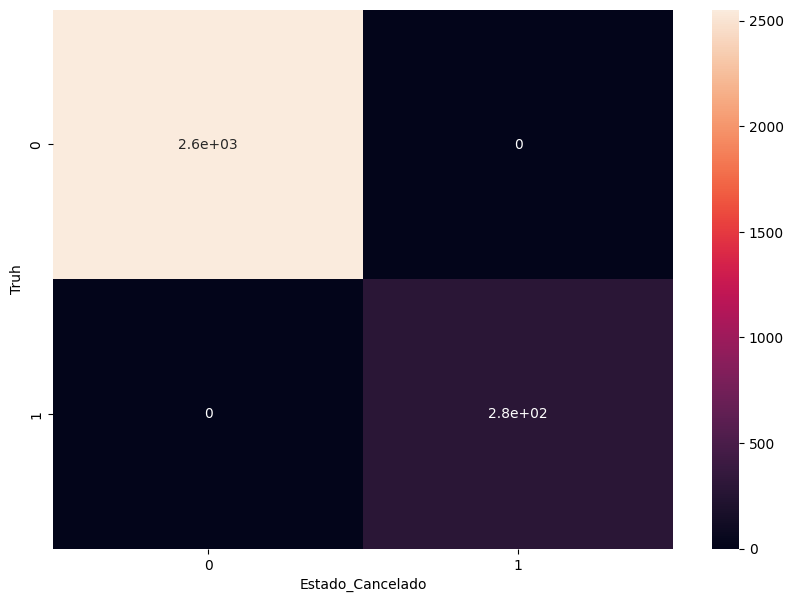

In [40]:
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test,RF_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm1,annot=True)
plt.xlabel('Estado_Cancelado')
plt.ylabel('Truh')

**CLARINETE QUE ESTO ESTá MUY DESCOMPENSADO. VAMOS A INTENTAR BALANCEAR LA MUESTRA**

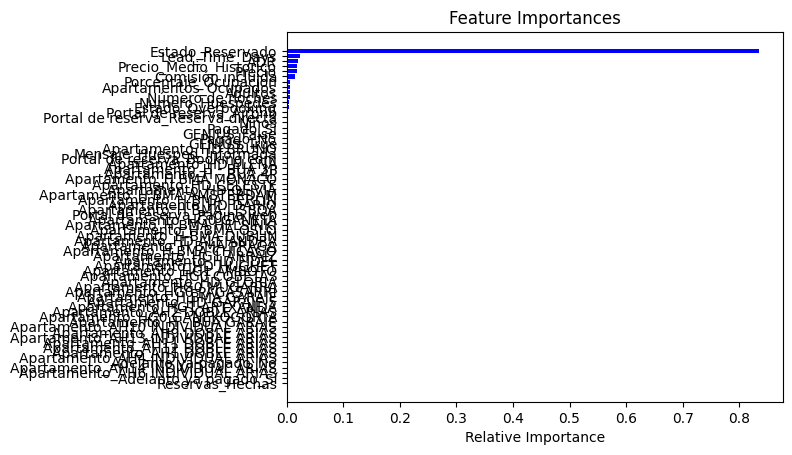

In [46]:
features = X_train.columns
importances = RF_model.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## 1. Submuestreo de la Clase Mayoritaria (Undersampling)
Puedes reducir el tamaño de la clase mayoritaria para equilibrar el número de muestras en cada clase. Esto puede ser efectivo si tienes una cantidad muy grande de datos en la clase mayoritaria, pero corres el riesgo de perder información valiosa.

In [48]:
from imblearn.under_sampling import RandomUnderSampler

# Definir el submuestreador
rus = RandomUnderSampler(random_state=42)

# Aplicar el submuestreo
X_resampled, y_resampled = rus.fit_resample(X, y)

## 2.  SMOTE 
(Synthetic Minority Over-sampling Technique) para balancear tu dataset

In [49]:
from imblearn.over_sampling import SMOTE

# Inicializar SMOTE
smote = SMOTE(random_state=42)

# Aplicar SMOTE al conjunto de entrenamiento
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Distribución antes de SMOTE: {y_train.value_counts()}")
print(f"Distribución después de SMOTE: {y_train_smote.value_counts()}")

Distribución antes de SMOTE: Estado_Cancelado
False    10208
True      1128
Name: count, dtype: int64
Distribución después de SMOTE: Estado_Cancelado
False    10208
True     10208
Name: count, dtype: int64


# B | DECISION TREE CLASSIFIER
Visto el éxito y que no podemos desbalancear, vamos a ver si eligiendo un modelo que se anjuste sólo mejor conseguimos algo más realista.


In [50]:
dt_base = DecisionTreeClassifier(random_state=0)

# 🎯 Nota: 

En este problema de reservas de hotel, la variable objetivo es Estado_Cancelado, que indica si una reserva fue cancelada (1) o no (0). Tanto los falsos positivos (una reserva se predice como cancelada, pero no lo está) como los falsos negativos (una reserva se predice como no cancelada, pero lo está) pueden ser costosos para el hotel.

Sin embargo, los falsos negativos pueden ser más costosos porque el hotel podría perder potenciales clientes al sobrebookear habitaciones, esperando cancelaciones que no ocurren. Por lo tanto, es importante minimizar los falsos negativos, lo que significa que maximizar el recall para la clase 'cancelada' (1) sería un buen enfoque.

La precisión (precision) también es importante porque minimiza los falsos positivos, lo que significa minimizar los casos en los que el modelo predice una cancelación, pero el huésped realmente llega. Esto podría llevar a un exceso de reservas y a clientes insatisfechos.

Por lo tanto, la F1-score, que es la media armónica de precisión y recall, sería una buena métrica para usar, ya que equilibra tanto la precisión como el recall. Específicamente, la F1-score para la clase 'cancelada' (1) sería la métrica más importante para evaluar los modelos en este proyecto.

Creamos la funcioón que identifica el conjunto de hiperparámetros que maximic el F1-score para la clase (Reservas Canceladas)

In [51]:
def tune_clf_hyperparameters(clf, param_grid, X_train, y_train, scoring='f1', n_splits=5):
    '''
    This function optimizes the hyperparameters for a classifier by searching over a specified hyperparameter grid. 
    It uses GridSearchCV and cross-validation (StratifiedKFold) to evaluate different combinations of hyperparameters. 
    The combination with the highest F1-score for class 1 (canceled bookings) is selected as the default scoring metric. 
    The function returns the classifier with the optimal hyperparameters.
    '''
    
    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

    # Create the GridSearchCV object
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring=scoring, n_jobs=-1)

    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    best_hyperparameters = clf_grid.best_params_
    
    # Return best_estimator_ attribute which gives us the best model that has been fitted to the training data
    return clf_grid.best_estimator_, best_hyperparameters

In [52]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11336 entries, 12157 to 4984
Data columns (total 66 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Adultos                            11336 non-null  float64
 1   Niños                              11336 non-null  float64
 2   Precio                             11336 non-null  float64
 3   Comisión incluida                  11336 non-null  float64
 4   Número de noches                   11336 non-null  int64  
 5   Numero_Huespedes                   11336 non-null  float64
 6   ADR                                11336 non-null  float64
 7   Precio_Medio_Historico             11336 non-null  float64
 8   Apartamentos_Ocupados              11336 non-null  float64
 9   Porcentaje_Ocupacion               11336 non-null  float64
 10  Lead_Time_Days                     11336 non-null  float64
 11  Reservas_Hechas                    11336 non-null  int64

# B.- GRID de HYPERPARÁMETROS.
Buscamos afinar el resultado de nuestro Arbol de Decisión.

In [53]:
# Hyperparameter grid for DT
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [13, 14, 15],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'class_weight': [{0: 1, 1: w} for w in [1, 2, 3]]
}

### Como no he conseguido balancear la muestra, le daremos un peso a uno de los parámetros.

In [54]:
best_dt, best_dt_hyperparams = tune_clf_hyperparameters(dt_base, param_grid_dt, X_train, y_train)

In [55]:
print('Mejor DT:', best_dt)

print('DT Optimal Hyperparameters: \n', best_dt_hyperparams)

Mejor DT: DecisionTreeClassifier(class_weight={0: 1, 1: 1}, max_depth=13, random_state=0)
DT Optimal Hyperparameters: 
 {'class_weight': {0: 1, 1: 1}, 'criterion': 'gini', 'max_depth': 13, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [56]:
DT_Hyperparameters_OPtimos = {
 'class_weight': {0: 1, 1: 1}, 
 'criterion': 'gini', 
 'max_depth': 13, 
 'min_samples_leaf': 1, 
 'min_samples_split': 2
 }

FUNCIÓN para SACAR las MÉTRICAS

In [57]:
def metrics_calculator(clf, X_test, y_test, model_name):
    '''
    This function calculates all desired performance metrics for a given model on test data.
    The metrics are calculated specifically for class 1.
    '''
    y_pred = clf.predict(X_test)
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, pos_label=1),
                                recall_score(y_test, y_pred, pos_label=1),
                                f1_score(y_test, y_pred, pos_label=1),
                                roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])],
                          index=['Accuracy','Precision (Class 1)','Recall (Class 1)','F1-score (Class 1)','AUC (Class 1)'],
                          columns = [model_name])
    
    result = (result * 100).round(2).astype(str) + '%'                            
    return result

FUNCIÓN para SACAR las MÉTRICAS de EVALUACIÓN

In [58]:
def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name):
    '''
    This function provides a complete report of the model's performance including classification reports, 
    confusion matrix and ROC curve.
    '''
    sns.set(font_scale=1.2)
    
    # Generate classification report for training set
    y_pred_train = clf.predict(X_train)
    print("\n\t  Classification report for training set")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    # Generate classification report for test set
    y_pred_test = clf.predict(X_test)
    print("\n\t   Classification report for test set")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))
    
    # Create figure and subplots 
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi=100, gridspec_kw={'width_ratios': [2, 2, 1]})
    
    # Define a colormap
    royalblue = LinearSegmentedColormap.from_list('royalblue', [(0, (1,1,1)), (1, (0.25,0.41,0.88))])
    royalblue_r = royalblue.reversed()

    # Plot confusion matrix for test set
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, colorbar=False, cmap=royalblue_r, ax=ax1)
    ax1.set_title('Confusion Matrix for Test Data')                                     
    ax1.grid(False)
    
    # Plot ROC curve for test data and display AUC score 
    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax2)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve for Test Data (Positive label: 1)')
    
    # Report results for the class specified by positive label
    result = metrics_calculator(clf, X_test, y_test, model_name)
    table = ax3.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(0.6, 2)
    table.set_fontsize(12)
    ax3.axis('tight')
    ax3.axis('off')
    # Modify color 
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color('royalblue')
    plt.tight_layout()
    plt.show() 


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     10208
        True       1.00      1.00      1.00      1128

    accuracy                           1.00     11336
   macro avg       1.00      1.00      1.00     11336
weighted avg       1.00      1.00      1.00     11336


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      2552
        True       1.00      1.00      1.00       282

    accuracy                           1.00      2834
   macro avg       1.00      1.00      1.00      2834
weighted avg       1.00      1.00      1.00      2834



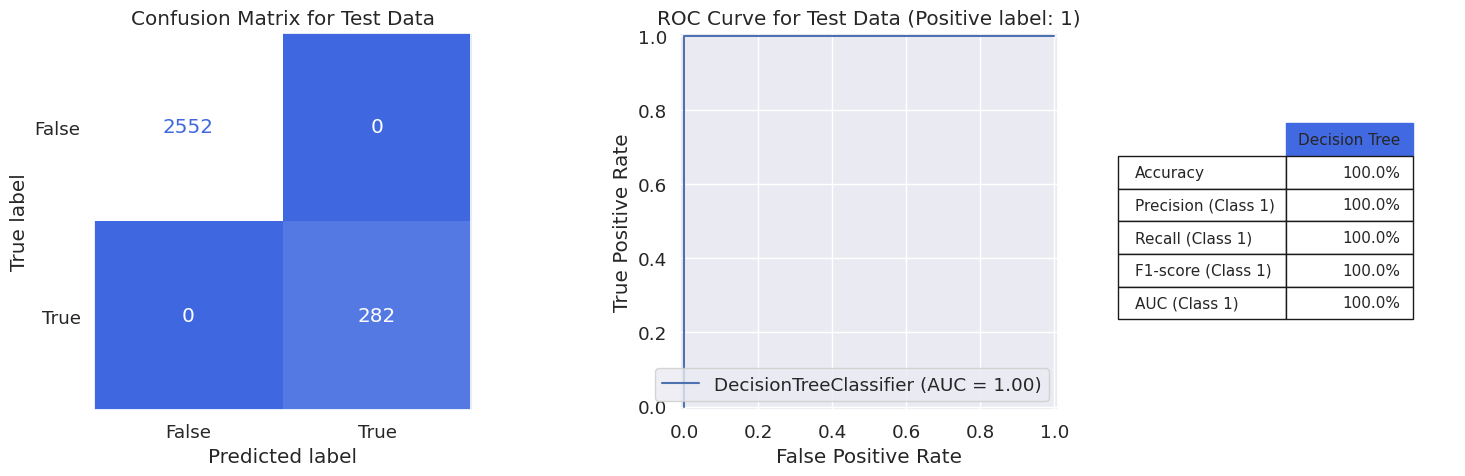

In [59]:
model_evaluation(best_dt, X_train, X_test, y_train, y_test, 'Decision Tree')

# C | XGBoost Model Building
eXtreme Gradient Boosting, es una implementación eficiente y escalable del método de gradient boosting. Es un algoritmo de aprendizaje automático basado en árboles de decisión que utiliza un marco de gradient boosting. Es especialmente popular y efectivo para tareas de clasificación y regresión, y ha ganado reputación por su rendimiento y velocidad en comparación con otras implementaciones de gradient boosting. XGBoost está diseñado para ser eficiente, flexible y portátil.

In [60]:
# Definimos el modelo
xgb_base = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)

In [61]:
# Define the parameter grid
param_grid_xgb = {
    'n_estimators': [250, 350],
    'learning_rate': [0.01, 0.1],
    'max_depth': [7, 8],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.8, 0.9],
    'scale_pos_weight': [1, (y_train == 0).sum() / (y_train == 1).sum()]
}

In [62]:
# Call the function for hyperparameter tuning
best_xgb, best_xgb_hyperparams = tune_clf_hyperparameters(xgb_base, param_grid_xgb, X_train, y_train)

/home/iraitz/TheBridge/FEB24 -BIL  DS PT/PROYECTO_FINAL_ML/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [09:24:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/iraitz/TheBridge/FEB24 -BIL  DS PT/PROYECTO_FINAL_ML/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [09:24:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/iraitz/TheBridge/FEB24 -BIL  DS PT/PROYECTO_FINAL_ML/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [09:24:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/iraitz/TheBridge/FEB24 -BIL  DS PT/PROYECTO_FINAL_ML/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [09:24:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_lab

In [63]:
print('XGBoost Optimal Hyperparameters: \n', best_xgb_hyperparams)

XGBoost Optimal Hyperparameters: 
 {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 250, 'scale_pos_weight': 1, 'subsample': 0.7}



	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     10208
        True       1.00      1.00      1.00      1128

    accuracy                           1.00     11336
   macro avg       1.00      1.00      1.00     11336
weighted avg       1.00      1.00      1.00     11336


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      2552
        True       1.00      1.00      1.00       282

    accuracy                           1.00      2834
   macro avg       1.00      1.00      1.00      2834
weighted avg       1.00      1.00      1.00      2834



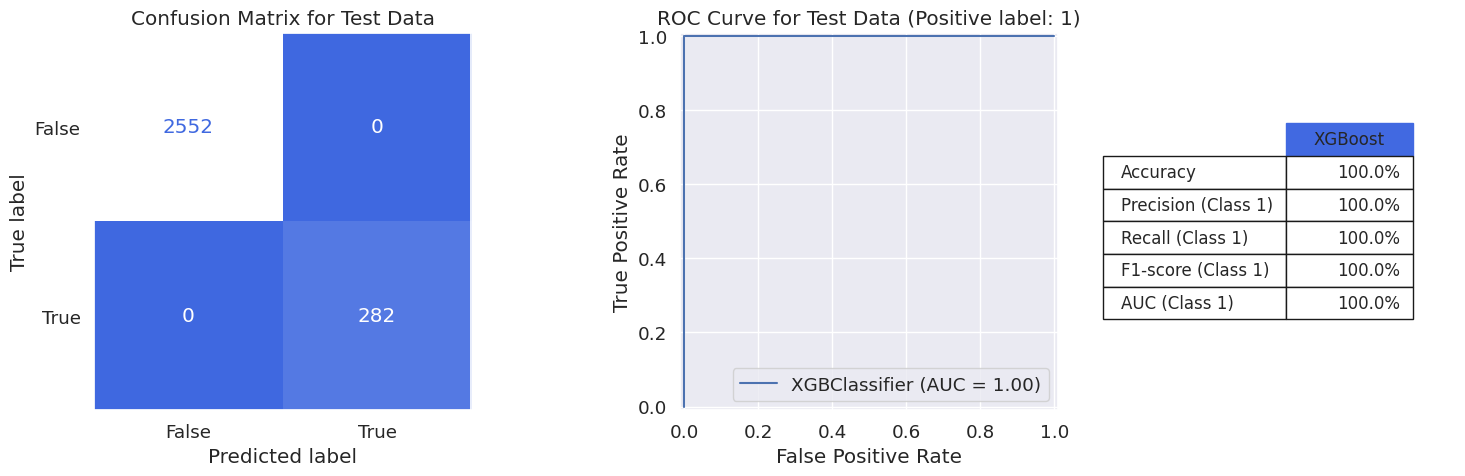

In [64]:
model_evaluation(best_xgb, X_train, X_test, y_train, y_test, 'XGBoost')

In [67]:
import joblib

joblib.dump(best_xgb,"../models/mi_mejor_modelo.joblib" )

['../models/mi_mejor_modelo.joblib']